# Lunar Lander Example

In this example, we will train an RL agent on the popular *Lunar Lander* environment. We will be using an implementation of the on-policy algorithm [Proximal Policy Optimisation (PPO)](https://spinningup.openai.com/en/latest/algorithms/ppo.html) provided by the Stable Baselines3 library.

The goal in this task is to savely land a lunar lander on the moon, ideally on a landing pad at position (0,0) in the randomly generated lunar landscape.

<img src="img/lunar_lander_trainig_1000000_steps.gif" width=33%/>

### Action

The agent can control the lunar lander by firing the main engine and two thrusters, one on each side of the lander.

### Observation

The agent can observe the lander's position and velocity in x and y, the landars orientation angle and angular velocity as well as whether the lander's legs are currently touching the ground.

### Reward

The lander receives negative rewards for moving away from the landing pad. Crashing is punished with a reward of -100. For each leg touching the ground, the lander receives +10 reward. When coming to rest anywhere on the ground, the lander receives +100 points. When coming to rest on the landing pad, the lander receives +200 points. Using fuel gives negative reward with the main engine costing -0.3 when fired and the side thrusters costing -0.03 when fired.

In [1]:
# Imports

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

from utils.rl.helpers import make_lunar_lander_training_gifs, plot_lunar_lander_training_history

First we need to create the environment. Environments contained in *Gym* can be created by running

```python
env = gym.make("LunarLander-v2")
```

with the environment's name. In order to facilitate faster training using multiple CPU cores, we use a so-called *vectorised environment*, where multiple of the same environment run in parallel. *Stable Baselines3* offers a convenience function `make_vec_env` to create vectorised versions of Gym environments.

In [2]:
venv = make_vec_env("LunarLander-v2", n_envs=16, vec_env_cls=SubprocVecEnv, monitor_dir="utils/rl/lunar_lander/monitors")

Then we create our PPO agent. These objects are the key component of Stable Baselines3 and contain the implementations of the RL algorithms as well as other utilities to handle inference, model saving and more.

The agent is configured to use a multi-layer perceptron (MLP) as its policy, the previously created environment for training and a number of known-to-work-well hyperparameters.

In [3]:
model = PPO("MlpPolicy", env=venv, n_steps=1024, batch_size=64, gae_lambda=0.98, gamma=0.999, n_epochs=4, ent_coef=0.01, verbose=0)

Now we can train. Training length/budget is measured in number of timesteps (interactions with the environment). 1 Million steps is known to work well for this particular example.

In [4]:
checkpoint_callback = CheckpointCallback(save_freq=6250, save_path="utils/rl/lunar_lander/checkpoints")

In [5]:
# Toggle comment to re-run the training (can take very long)
# model.learn(total_timesteps=int(1e6), callback=checkpoint_callback)

Let's checkout how the episode reward and episode length developed throughout the training.

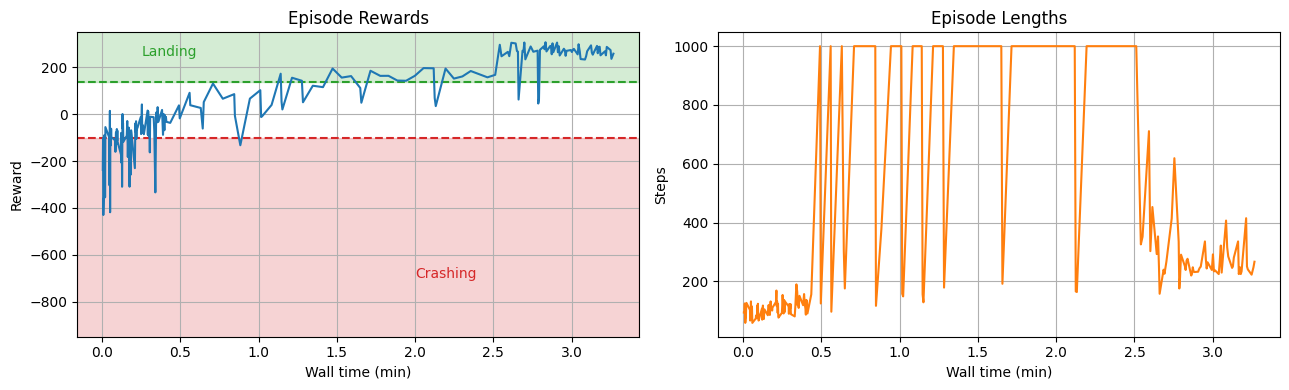

In [6]:
plot_lunar_lander_training_history()

We can also look at the agent trying to land the lunar lander at different stages of the training.

In [7]:
make_lunar_lander_training_gifs()

<div>
    <img src="img/lunar_lander_trainig_100000_steps.gif" width=33%/>
    <img src="img/lunar_lander_trainig_300000_steps.gif" width=33%/>
    <img src="img/lunar_lander_trainig_1000000_steps.gif" width=33%/>
</div>

Now we can load the trained model and try it.

In [8]:
loaded_model = PPO.load("utils/rl/lunar_lander/checkpoints/rl_model_1000000_steps")
env = gym.make("LunarLander-v2")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
env.close()